In [1]:
import pandas as pd
import numpy as np
import re
import json
import nltk
from nltk.corpus import stopwords

from numpy import array
import keras
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Conv1D,GlobalMaxPooling1D,MaxPooling1D
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint

from numpy import array
from numpy import asarray
from numpy import zeros

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd drive/
%cd 'My Drive'
%cd Colab\ Notebooks
%cd NLP_Assignment/
!ls

/content/drive
/content/drive/My Drive
/content/drive/My Drive/Colab Notebooks
/content/drive/My Drive/Colab Notebooks/NLP_Assignment
best_validation_weights.h5	      movie_data.csv
glove.6B.100d.txt		      test.txt
hin_eng.json			      train.txt
hin_eng_mixed_sentiment_word2vec.txt  words_not_found.txt
model.png


#Preprocessing Train Text


In [0]:
fs_train = open('train.txt','r')
arr_train = fs_train.readlines()
sent_words_train = []
temp_train = []
for i in range(len(arr_train)-1):
  if('meta' not in arr_train[i+1]):
    temp_train.append(arr_train[i])
  else:
    sent_words_train.append(temp_train)
    temp_train = []

y_temp = []
x_temp = []

for i in sent_words_train:
  
  y_temp.append(i[0])
  x_temp.append(i[1:])

x_temp2 = []
for i in x_temp:
  tmp = []
  for j in i:
    s = j.split('\t')
    tmp.append(s[0])
  x_temp2.append(' '.join(tmp))

# x_temp2
y_temp2 = []
for i in y_temp:
  s = i.split('\t')
  if(s[-1][:-1]=='negative'):
    y_temp2.append(0)
  elif(s[-1][:-1]=='neutral'):
    y_temp2.append(1)
  else:
    y_temp2.append(2)

# y_temp2
fs_train.close()
ff = open('words_not_found.txt','r')
nfw = ff.readlines()
not_found_words = []
for i in nfw:
  not_found_words.append(i[:-1])

# print(not_found_words)
ff.close()
fj = open('hin_eng.json')
hineng = json.load(fj)
fj.close()



x_train = []
for i in x_temp2:
  m = re.sub(r'@','',i)
  n = re.sub(r'#','',m)
  o = re.sub(r'_','',n)
  x_train.append(re.sub(r'https.*$','',o))

# y_temp2

y_train = keras.utils.to_categorical(y_temp2, num_classes=None, dtype='float32')

x_tt = []
for i in x_train:
  x_tt.append(i.split())

# print(x_tt[:100])
# for i in range(len(x_tt)):
#   for j in range(len(x_tt[i])):
#     if(x_tt[i][j] in not_found_words):
#       if(x_tt[i][j] in hineng):
#         # print(x_tt[i],x_tt[i][j],hineng[x_tt[i][j]])
#         x_tt[i][j] = hineng[x_tt[i][j]]
        
# x_train_new = []
# for i in x_tt:
#   x_train_new.append(' '.join(i))

# print(len(x_train_new))
# print(len(x_train))
# x_train = x_train_new



#Preprocessing Test Corpus

In [0]:
fs_test = open('test.txt','r')
arr_test = fs_test.readlines()
sent_words_test = []
temp_test = []
for i in range(len(arr_test)-1):
  if('meta' not in arr_test[i+1]):
    temp_test.append(arr_test[i])
  else:
    sent_words_test.append(temp_test)
    temp_test = []

y_temp = []
x_temp = []

for i in sent_words_test:
  
  y_temp.append(i[0])
  x_temp.append(i[1:])

x_temp2 = []
for i in x_temp:
  tmp = []
  for j in i:
    s = j.split('\t')
    tmp.append(s[0])
  x_temp2.append(' '.join(tmp))

# x_temp2
y_temp2 = []
for i in y_temp:
  s = i.split('\t')
  if(s[-1][:-1]=='negative'):
    y_temp2.append(0)
  elif(s[-1][:-1]=='neutral'):
    y_temp2.append(1)
  else:
    y_temp2.append(2)

# y_temp2

x_test = []
for i in x_temp2:
  m = re.sub(r'@','',i)
  x_test.append(re.sub(r'https.*$','',m))

# y_temp2

y_test = keras.utils.to_categorical(y_temp2, num_classes=None, dtype='float32')

len(x_test)
fs_test.close()

#Tokenising

In [0]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train+x_test)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
# x_train

In [7]:
vocab_size_train = len(tokenizer.word_index) + 1

maxlen = 100

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)
vocab_size_train

47521

#Processing Glove Embeddings File

In [0]:

embeddings_dictionary_train = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary_train [word] = vector_dimensions
glove_file.close()

#Generating Embedding Matrix

In [9]:
count = 0
words_not_found = []
embedding_matrix_train = zeros((vocab_size_train, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary_train.get(word)
    if embedding_vector is not None:
        embedding_matrix_train[index] = embedding_vector
    else:
      count+=1
      words_not_found.append(word)

count
# f = open("words_not_found.txt", "w")
# for i in words_not_found:
#   f.write(i+"\n")
# f.close()


30548

#Recall Precision f1

In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#Model

In [11]:
model = Sequential()
model.add(Embedding(vocab_size_train, 100, weights=[embedding_matrix_train], input_length=maxlen))

model.add(Conv1D(128, 4, activation='relu',padding='same'))
model.add(Conv1D(128, 8, activation='relu',padding='same'))
model.add(Dropout(0.3))
model.add(Conv1D(128, 16, activation='relu',padding='same'))
model.add(Conv1D(128, 32, activation='relu',padding='same'))

model.add(MaxPooling1D(pool_size = 2))
model.add(Dropout(0.3))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
# model.add(LSTM(128))

model.add(Dense(3, activation='softmax'))
loss1 = 'categorical_crossentropy'
# loss1 = 'sparse_categorical_crossentropy'
model.compile(optimizer='adam', loss=loss1, metrics=['acc',f1_m,precision_m, recall_m])











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.





#Model Fit

In [12]:
checkpoint = ModelCheckpoint('best_validation_weights.h5',monitor='val_loss', verbose=0,save_best_only=True, save_weights_only=True)
callback = [checkpoint]
model.fit(x_train, y_train, batch_size=128, epochs=12, verbose=1, validation_data=(x_test,y_test),callbacks=callback)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 15132 samples, validate on 1869 samples
Epoch 1/12
15132/15132 [==============================] - 5s 329us/step - loss: 0.9831 - acc: 0.4849 - f1_m: 0.2749 - precision_m: 0.5886 - recall_m: 0.1895 - val_loss: 0.9992 - val_acc: 0.4735 - val_f1_m: 0.3849 - val_precision_m: 0.5257 - val_recall_m: 0.3039
Epoch 2/12
15132/15132 [==============================] - 2s 151us/step - loss: 0.8600 - acc: 0.5825 - f1_m: 0.4948 - precision_m: 0.6474 - recall_m: 0.4046 - val_loss: 0.9529 - val_acc: 0.5308 - val_f1_m: 0.4407 - val_precision_m: 0.6009 - val_recall_m: 0.3488
Epoch 3/12
15132/15132 [==============================] - 2s 153us/step - loss: 0.7696 - acc: 0.6462 - f1_m: 0.6174 - precision_m: 0.6801 - recall_m: 0.5663 - val_loss: 0.9758 - val_acc: 0.5190 - val_f1_m: 0.4726 - val_precision_m: 0.5739 - val_recall_m: 0.4024
Epoch 4/12
15132/15132 [==============================] - 2s 151us/st

#Model Evaluate

In [13]:
model.evaluate(x_test, y_test, verbose=1)

1869/1869 [==============================] - 0s 164us/step


[1.8036798962684415,
 0.5393258428879764,
 0.5332733879694013,
 0.5364592127011637,
 0.5302300697472594]

In [14]:
from sklearn.metrics import classification_report
y = np.argmax(model.predict(x_test),axis=1)
y
print(classification_report(np.argmax(y_test,axis=1),y))

              precision    recall  f1-score   support

           0       0.59      0.49      0.54       532
           1       0.51      0.54      0.52       754
           2       0.55      0.58      0.56       583

    accuracy                           0.54      1869
   macro avg       0.55      0.54      0.54      1869
weighted avg       0.54      0.54      0.54      1869



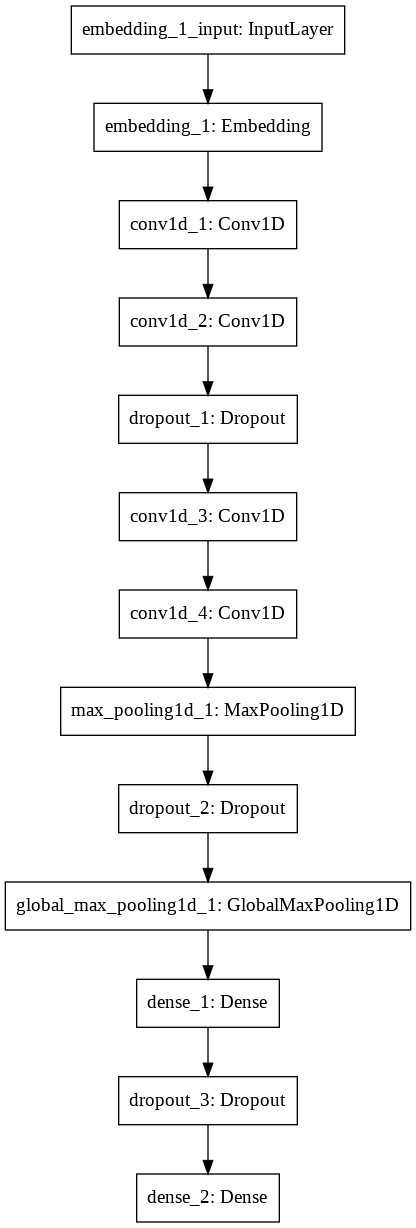

In [15]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')